# Fill the Matrix 
In this notebook we fill the values of the matrix

In [1]:
from time import time
import psycopg2
from collections import Counter
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True,precision=10)

In [2]:
def cleanMatrix(dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = ("DELETE "
                      " FROM matrix"
    )
    cur.execute(select_stament)
    conn.commit()
    cur.close()
    conn.close()

In [3]:
def selectWord(dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = '''SELECT subject_id,word,isalive 
    FROM subjectwords 
    WHERE ((isalive=0 AND length(word)>15000) OR isalive=1) 
    ''' 
    #    AND length(word)>1000
    cur.execute(select_stament)
    select = []
    for row in cur :
        select.append({'subject_id':row[0],'word':row[1],'isalive':row[2]})
    conn.close()
    return select

In [4]:
def get_all_substrings(input_string,minimun=0,maximun=5):
    substrings = []
    for j in range(len(input_string)) :
        for i in range(minimun,maximun) :
            substring = input_string[j:j+i+1]
            if len(substring)>minimun :
                substrings.append(substring)
    return Counter(substrings)

In [5]:
def saveMatrix(matrix,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    insert_statement=('INSERT INTO matrix(word,subject_id,counting)'
                      ' SELECT unnest( %(word)s ) ,'
                      ' unnest( %(subject_id)s) ,'
                      ' unnest( %(counting)s)')
    word=[r['word'] for r in matrix]
    subject_id=[r['subject_id'] for r in matrix]
    counting=[r['counting'] for r in matrix]
  #  print(cur.mogrify(insert_statement,locals()))
    cur.execute(insert_statement,locals())
    conn.commit()
    cur.close()
    conn.close()

In [6]:
def fillMatrix(minimun=0,maximun=5):
    t0 = time()
    cleanMatrix()
    i,lenMatrix=0,0
    for word in selectWord() :
        matrix = []
        subject = word['subject_id']
        subs =get_all_substrings(word['word'],minimun,maximun)
        for key in subs:
            matrix.append({'word':key,'counting':subs[key],'subject_id':subject})
        if matrix!=[]:
            saveMatrix(matrix)
        lenMatrix=lenMatrix+len(matrix)
    print("The matrix was filled with "+str(lenMatrix)+" values.")
    print("fillMatrix done in %0.3fs." % (time() - t0))

In [7]:
def fixMatrix(dbname="mimic") :
    t0 = time()
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = ("DELETE "
                      " FROM matrix"
                      " WHERE word in (SELECT word FROM matrix GROUP BY word HAVING sum(counting)<5)"
    )
    cur.execute(select_stament)
    select_stament = '''DELETE 
    FROM matrix 
    WHERE word IN (SELECT word FROM matrix group by word HAVING count(1)>=(
    SELECT count(distinct subject_id) FROM matrix))
    '''
    cur.execute(select_stament)
    conn.commit()
    cur.close()
    conn.close()
    print("fixMatrix done in %0.3fs." % (time() - t0))

In [8]:
def selectMatrix(dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = ("SELECT m.subject_id,m.word,m.counting,s.isalive "
                      " FROM matrix m LEFT JOIN subjectwords s ON m.subject_id=s.subject_id"
    )
    cur.execute(select_stament)
    select = []
    for row in cur :
        select.append((row))
    cur.close()
    conn.close()
    return select

In [9]:
def heartBeatDeads(dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = '''SELECT DISTINCT word FROM matrix 
    WHERE subject_id IN (SELECT subject_id FROM subjectwords WHERE isalive=1)
    AND subject_id IN (SELECT subject_id FROM subjectwords WHERE isalive=0)'''
    cur.execute(select_stament)
    select = []
    for row in cur :
        select.append(row[0])
    cur.close()
    conn.close()
    print(len(select))
    return select

In [10]:
def deleteOnlyAlive(heardBeatDeads,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = ("DELETE "
                      " FROM matrix"
                      " WHERE word in %s"
    )
#    print(cur.mogrify(select_stament,(heardBeatDeads,)))
    cur.execute(select_stament,(heardBeatDeads,))
    conn.commit()
    cur.close()
    conn.close()

In [11]:
def convertMatrix() :
    t0 = time()
    labels = ['subject_id', 'Word', 'Counting','isAlive']
    df = pd.DataFrame.from_records(selectMatrix(), columns=labels)
    print(len(df))
    table = pd.pivot_table(df,index=["subject_id","isAlive"],columns=["Word"],values=["Counting"],
                       aggfunc={"Counting":[np.sum]},fill_value=0)
    table.columns = [value[2] for value in table.columns.values]
    print("converMatrix done in %0.3fs." % (time() - t0))
    print(table.shape)
    gc.collect()
    return table

In [12]:
def printSurvivor(survived):
    labels = 'survived', 'died'
    sizes = [survived.count(0),survived.count(1)]
    fig1, ax1 = plt.subplots()
    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
        return my_autopct
    ax1.pie(sizes, labels=labels, autopct=make_autopct(sizes),
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()#609 313

In [13]:
fillMatrix(minimun=4,maximun=5)

The matrix was filled with 240592 values.
fillMatrix done in 26.610s.


In [14]:
fixMatrix()

fixMatrix done in 0.814s.


In [15]:
#deadBeats = heartBeatDeads()
#deleteOnlyAlive(tuple(deadBeats))

In [16]:
table = convertMatrix()

215812
converMatrix done in 3.584s.
(737, 5853)


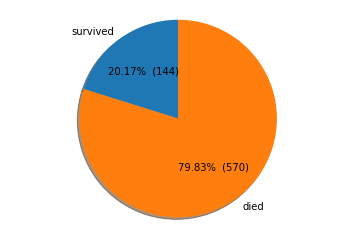

In [24]:
printSurvivor(table.index.labels[1].tolist())

In [19]:
table

,,aaaaa,aaaab,aaaac,aaaad,aaaae,aaaaf,aaaag,aaaah,aaaai,aaaaj,...,lbbbb,lbbcb,lbcbb,leeee,libbb,liiii,liiil,liili,lilii,lliii
subject_id,isAlive,,,,,,,,,,,,,,,,,,,,,
20,0,13957,403,0,19,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85,1,13,15,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
135,1,13957,749,0,22,0,1,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
151,1,5897,1046,2,93,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
177,1,7577,212,0,12,0,11,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
214,1,10787,318,2,55,0,34,9,0,0,0,...,0,0,0,0,0,0,0,0,0,0
263,1,12149,24,0,1,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
279,1,145,131,0,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
283,1,103,100,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
def findAverage(table):
    numRegs,count = 0,0
    for value in table.columns:
        total = table[value].sum()
        numRegs += total
        count +=1
    average =int(numRegs/count)
    print(numRegs,count,"average",average)
    return average

In [21]:
def findUnderAverage(table):
    count=0
    underaverage = []
    average=findAverage(table)
    for value in table.columns:
        total = table[value].sum()
        if total>average:
            underaverage.append(value)
            count+=1
#            print("%s:%d" %(value,total,),end="|")
    return underaverage

In [22]:
underaverage = findUnderAverage(table)
deleteOnlyAlive(tuple(underaverage))

9216640 5853 average 1574


In [23]:
table = convertMatrix()
print(table)

135033
converMatrix done in 3.536s.
(714, 5621)
                    aaaae  aaaah  aaaai  aaaaj  aaabe  aaabf  aaabg  aaabh  \
subject_id isAlive                                                           
85         1            0      0      0      0      0      0      0      0   
135        1            0      0      0      0      0      0      0      0   
151        1            0      0      0      0      0      1      0      0   
177        1            0      0      0      0      0      0      0      0   
214        1            0      0      0      0      0      9      3      0   
263        1            0      0      0      0      0      0      0      0   
279        1            0      0      0      0      0      1      1      0   
283        1            0      0      0      0      0      0      0      0   
368        1            0      0      0      0      0      0      0      0   
377        1            1      2      0      1      0      5      2      1   
408        1    